# **■■ STL10のデータセットを用いた、画像認識モデルの構築 ～AlexNet風～ ■■**



## **◆目次**


* はじめに
* ライブラリのインポート
* AlexNet風CNNの実装
* Pathの定義
* データの前処理と読み込みの定義
* 学習・評価関数の定義
* 可視化の定義
* 学習前の設定
* モデルの初期化
* 学習ループの実行
* モデルの可視化
* おわりに


## **▼はじめに**


本ノートブックでは、  
STL10のデータセットを用いた画像認識モデルの構築に取り組んでいます。  
  
AlexNetの構造を参考に、自身でモデルを設計し、STL10の画像分類に挑戦した結果、 **74.65%の精度** を達成しました。  
次回のノートブックでは、**ResNet層構造**を導入し、さらなる精度向上を目指します。  
また、 **データ拡張（Augmentation）** や **モデルの可視化** なども取り入れ、画像認識への理解を一層深めていきます。


## **▼ライブラリのインポート**


In [ ]:
# セッション再起動後、再度AllRun
!pip install torchinfo
!pip install torchcam

In [2]:
import os
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

# deviceの設定
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


必要なライブラリをインポートします。
* *"tqdm"* : プログレスバー表示用
* *"matplotlib"* : グラフ描画用
* *"torch"*, *"torch.nn"* : PyTorchの基本モジュール
* *"torchinfo"* : モデルの詳細表示用
* *"torchvision"* : データセットや画像変換用
* *"torchcam"* : Class Activation Map表示用

## **▼AlexNet風CNNの実装**


### **AlexNetとは？**


**AlexNet（アレックスネット）** とは、  
2012年の画像認識コンテスト「ImageNet Large Scale Visual Recognition Challenge（ILSVRC）」で、圧倒的な成績を収めたことで知られる、深層学習における歴史的なモデルです。  
  
従来の画像認識手法を大きく上回る精度を達成し、**畳み込みニューラルネットワーク（CNN）** の実用性を世界に示したモデルとして、  
多くの後続モデル（VGG, ResNetなど）にも影響を与えております。  

### **AlexNetの構造（概要）**


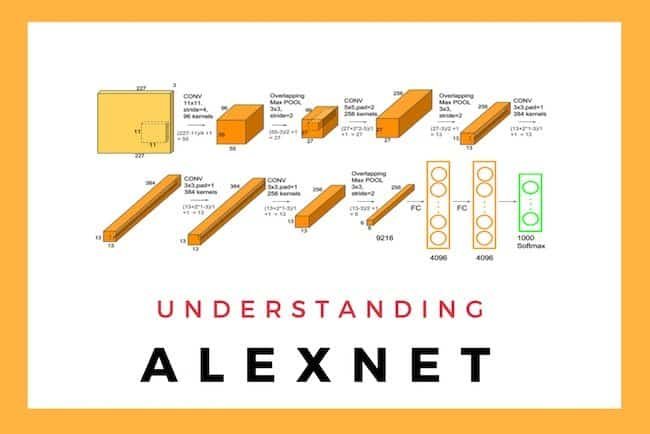


～ **AlexNetの特徴** ～

* 入力画像： 227×227（ILSVRCは224×224、今回はSTL10に合わせて96×96に変更）
* サイズ変化：（227×227=>55×55）=>27×27=>13×13=>13×13=>13×13=>6×6=>FC（9216=>4096=>4096=>1000）
* 5つの畳み込み層（Convolutional layers）
* 3つの全結合層（Fully-connected layers）
* ReLU活性化関数
* 最大プーリング（MaxPooling）
* ドロップアウト（Dropout）による過学習防止
* Softmaxによる分類（出力が確率）

この構造により、画像からエッジ・模様・形状といった特徴を **階層的に抽出** し、  
最終的に分類することが可能になります。  

～ **AlexNetの利点** ～

* **構造がシンプル** で理解しやすく、カスタマイズをしやすい
* 性能と計算コストの **バランス** がよく、STL10のような中規模のデータセットに適している
* 画像認識の畳み込みにおいて、効率の良い構築としての **知見** が深まる


### **AlexNet風CNNの構築**


In [3]:
# モデルの定義(AlexNet風CNN)
class CNN_a_la_AlexNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleDict({                                                       # サイズの変化
            "layer1": nn.Sequential(                                                        # 96*96 => 32*32
                nn.Conv2d(input_dim, hidden_dim, kernel_size=5, stride=3, padding=1),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU()
            ),
            "layer2": nn.Sequential(                                                        # 32*32 => 16*16
                nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(hidden_dim*2),
                nn.ReLU()
            ),
            "layer3": nn.Sequential(                                                        # 16*16 => 8*8
                nn.Conv2d(hidden_dim*2, hidden_dim*4, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(hidden_dim*4),
                nn.ReLU()
            ),
            "layer4": nn.Sequential(                                                        # 8*8 => 8*8
                nn.Conv2d(hidden_dim*4, hidden_dim*6, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(hidden_dim*6),
                nn.ReLU()
            ),
            "layer5": nn.Sequential(                                                        # 8*8 => 8*8
                nn.Conv2d(hidden_dim*6, hidden_dim*8, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(hidden_dim*8),
                nn.ReLU ()
            ),
            "pooling": nn.AdaptiveAvgPool2d(output_size=(1, 1)),                            # 8*8 => 1*1
            "flatten": nn.Flatten(),                                                        # hidden_dim*16*1*1 を 1次元 に
            "dropout": nn.Dropout(dropout),
            "fc": nn.Linear(hidden_dim*8, output_dim)                                      # hidden_dim*16 => 10(output_dim)
        })

    def forward(self, x):
        for layer in self.layers.values():
            x = layer(x)
        return x


～ **モデルの構築策定** ～

今回、STL10の画像認識のAlexNet風CNNを構築をするにあたり、   

* **96×96=>32×32=>16×16=>8×8=>8×8=>8×8**  のサイズ収縮が最適
* 8×8の小領域単位での畳み込みの **繰り返し** が有効
* 細部の情報を繊細に抽出するため、サイズを **96=>8** まで一気に収縮し、はじめに余分な情報を削減
* SiLUを導入し、正規化を活かす方針
* 最終段に **AdaptiveAvgPool2d** を導入し、出力サイズを安定させ、情報損失を防ぐ
* Dropoutによる、汎用性の向上

などの構想を策定し、モデル構築に取り組みました。

出力サイズ（Output size）の計算式：
$$
\text{Output Size} = \left\lfloor \frac{\text{Input Size} + 2 \times \text{Padding} - \text{Kernel Size}}{\text{Stride}} \right\rfloor + 1  
$$

## **▼Pathの定義**


In [4]:
def get_paths():
    # 相対パスの取得
    path = Path(".")

    # Pathの設定
    data_path = path / "data"

    input_path = data_path / "input"
    model_path = data_path / "model"

    bestmodel_path = model_path / "best_model.pth"

    # フォルダの作成
    input_path.mkdir(parents=True, exist_ok=True)
    model_path.mkdir(parents=True, exist_ok=True)

    return bestmodel_path, input_path

input用フォルダ・model用フォルダを作成し、bestmodel用のパスも設定します。


## **▼データの前処理と読み込みの定義**


In [5]:
# データの前処理と読み込み
def get_loader(root, mean, std, batch_size, num_workers):
    # データの拡張(Augmentation)の設定（下記に詳細あり）
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(96, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    transform_test = transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # STL10データセットの取得
    train_datasets = datasets.STL10(root, split='train', download=True, transform=transform_train)
    test_datasets = datasets.STL10(root, split='test', download=True, transform=transform_test)

    # ローダーの設定
    train_dataloader = DataLoader(train_datasets, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_dataloader = DataLoader(test_datasets, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_dataloader, test_dataloader

データセットを読み込み、前処理を行います。


～ **STL10とは？** ～

* 96×96pixelのカラー画像
* 10クラスの物体分類データセット
* train: 5,000枚（各クラス500枚）、test: 8,000枚（各クラス800枚）
* クラス: 飛行機、自動車、鳥、猫、鹿、犬、カエル、馬、船、トラック

～ **前処理** ～

* train: データ拡張（Augmentation）を適用し、汎用性の向上
* test: 正規化のみ（データ拡張なし）
* 正規化: 0～1の数値の mean を0になるようにして、 std の幅が1になるように設定


～ **データ拡張** ～

* RandomResizedCrop: 画像のランダム切り抜き
* RandomHorizontalFlip: 画像の左右反転
* RandomVerticalFlip: 画像の上下反転
* ColorJitter: 画像の色ランダム調整
* Resize: 画像サイズの調整
* ToTensor: 0～255 を 0～1 のテンソル型変換
* Normalized: 正規化

## **▼学習・評価関数の定義**


### **学習関数（train）の定義**


In [6]:
def train(model, train_dataloader, criterion, optimizer, device):
    # 訓練モード
    model.train()

    # 変数の設定
    total = 0
    loss_total = 0
    correct = 0

    # progress barの設定
    pbar = tqdm(train_dataloader, desc="    train")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # 勾配初期化
        optimizer.zero_grad()

        # 予測の出力
        outputs = model(images)

        # 予測に基づくロス計算と最適化
        total += len(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # ロスと正確度の算出
        loss_total += loss.item()
        outputs, labels = outputs.cpu(), labels.cpu()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()

        # ロスと正確度の表示(progress bar)
        pbar.set_postfix({
            "Loss": f"{loss_total / (pbar.n+1):.4f}",
            "Acc": f"{100 * correct / total:.2f}%"
        })

    # ロスと正確度の算出
    loss = loss_total / len(train_dataloader)
    acc = 100 * correct / total

    return loss, acc

### **評価関数（evaluate）の定義**


In [7]:
def evaluate(model, test_dataloader, criterion, device):
    # 評価モード
    model.eval()

    # 変数の設定
    total = 0
    loss_total = 0
    correct = 0

    # 勾配計算の無効化
    with torch.no_grad():

        # progress barの設定
        pbar = tqdm(test_dataloader, desc="    test ")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            # 予測とロスの出力
            outputs = model(images)
            loss = criterion(outputs, labels)

            # ロスと正確度の算出
            total += len(labels)
            loss_total += loss.item()
            outputs, labels = outputs.cpu(), labels.cpu()
            predict = torch.argmax(outputs, dim=1)
            correct += (predict == labels).sum().item()

            # ロスと正確度の表示(progress bar)
            pbar.set_postfix({
                "Loss": f"{loss_total / (pbar.n+1):.4f}",
                "Acc": f"{100 * correct / total:.2f}%"
            })

        # ロスと正確度の算出
        loss = loss_total / len(test_dataloader)
        acc = 100 * correct / total

    return loss, acc

* tqdm の プログレスバー によって、進捗を可視化
* 学習曲線の作図のため、返り値に各 loss と acc を設定

## **▼可視化の定義**


### **画像の表示の定義**


In [8]:
# 元画像に戻す関数の定義
def denormalize(x_norm, mean, std):
    return x_norm * std + mean

In [9]:
# 画像の出力の定義
def show_images_STL10(dataloader, rows=3, model=None):
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        break

    # 画像の表示の設定
    label_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
    plt.figure(figsize=(16, 6))
    for i in range(8*rows):
        plt.subplot(rows, 8, i+1)
        image = images[i]
        image = denormalize(image, 0.4, 0.3)
        plt.imshow(image.permute(1, 2, 0).cpu())

        label = label_names[labels[i].item()]

        # model != None の場合
        if model is not None:
            model.eval()
            with torch.no_grad():
                outputs = model(images[i].unsqueeze(0))
                predict = torch.argmax(outputs, dim=1)
                model_label = label_names[predict.item()]

                # 出力が正解の場合、緑
                if label == model_label:
                    plt.title(f"{label} / {model_label}", color="green")

                # 出力が不正解の場合、赤
                else:
                    plt.title(f"{label} / {model_label}", color="red")
            plt.axis('off')

        # model == None の場合
        else:
            plt.title(label)
            plt.axis('off')

    # 画像の表示
    plt.tight_layout()
    plt.show()

### **学習曲線の表示の定義**


In [10]:
def show_learning_curve(train_losses, train_accs, test_losses, test_accs):
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="train", color="blue", alpha=0.6)
    plt.plot(test_losses, label="test", color="red", alpha=0.6)
    plt.title("Learning Curve - Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="train", color="blue", alpha=0.6)
    plt.plot(test_accs, label="test", color="red", alpha=0.6)
    plt.title("Learning Curve - Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### **Class Activation Mapの表示の定義**


In [11]:
def show_CAM_STL10(test_dataloader, model):
    # ベストモデルの認識の可視化
    for images, _ in test_dataloader:
        images = images.to(device)
        break

    plt.figure(figsize=(16, 3))

    # 評価モード
    model.eval()

    for i in range(8):
        # 画像認識の抽出設定
        cam_extractor = SmoothGradCAMpp(model, target_layer=model.layers["layer5"])

        # 画像の出力抽出
        image = images[i].unsqueeze(0)

        # 勾配計算を可能にするために、入力画像にrequires_gradをTrueに設定
        image.requires_grad_(True)

        output = model(image)
        output = output.cpu()
        class_idx = torch.argmax(output, dim=1).item()

        # 抽出の画像化
        activation_map = cam_extractor(class_idx, output)

        # 元画像との合成
        result = overlay_mask(
            to_pil_image(image.squeeze(0).cpu().detach()),
            to_pil_image(activation_map[0].squeeze(0), mode="F"),
            alpha=0.5
        )

        # 画像の表示設定
        plt.subplot(1, 8, i+1)
        plt.imshow(result)
        plt.axis('off')

        # 抽出用ホックの削除
        cam_extractor.remove_hooks()

    # 画像の表示
    plt.tight_layout()
    plt.show()

    # 比較用画像の表示
    show_images_STL10(test_dataloader, 1, model)

～ **Class Activation Map（CAM）** とは？ ～  

モデルが画像を分類する際に「どの部分に注目して判断したのか」を可視化したものです。  
モデル内部の特徴マップと、出力層の重み情報を組み合わせることで、  
**「この画像のどこがそのクラスらしさに貢献しているか」** を視覚的に理解することができます。  

## **▼学習前の設定**


In [12]:
# pathの設定
bestmodel_path, input_path = get_paths()

# ハイパーパラメータの設定
root = input_path
batch_size = 64
num_workers = 4
lr = 0.0005
EPOCH = 200
best_acc = 0

# モデルのパラメータ設定
input_dim = 3
hidden_dim = 96
output_dim=10
dropout = 0.2

# データローダーの取得
print("STL10 の データセットを読み込んでいます...")
train_dataloader, test_dataloader = get_loader(root, 0.4, 0.3, batch_size, num_workers=num_workers)
print("STL10 の データセットの読み込みを完了しました。")

STL10 の データセットを読み込んでいます...


100%|██████████| 2.64G/2.64G [04:21<00:00, 10.1MB/s]


STL10 の データセットの読み込みを完了しました。


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


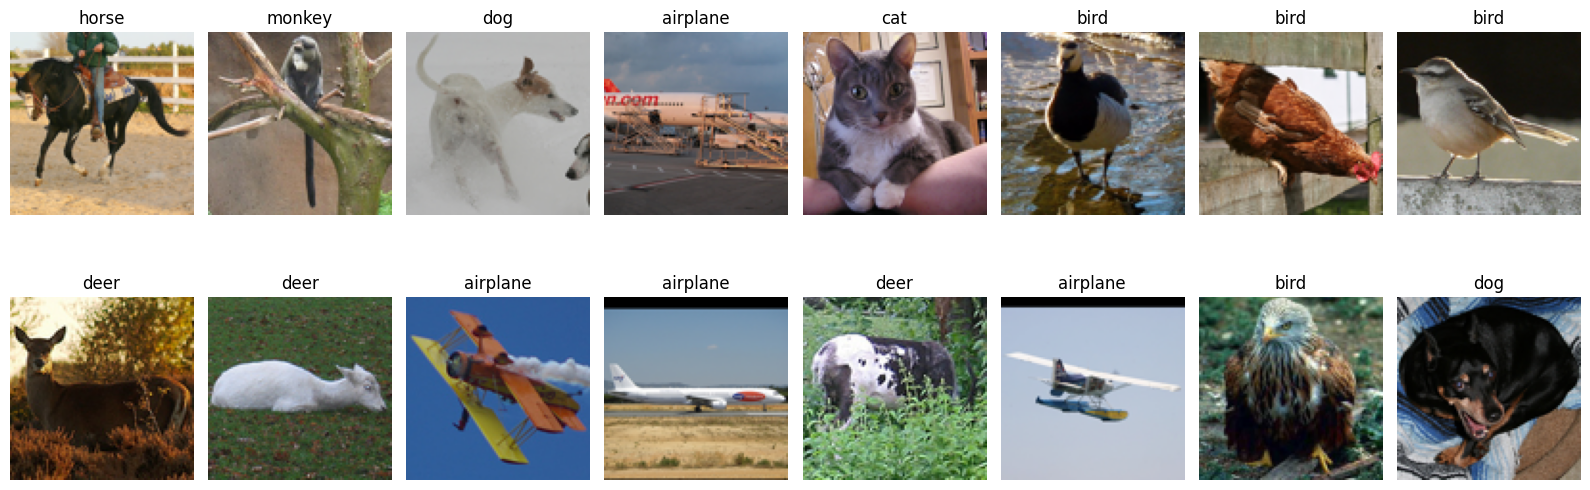

In [13]:
# テスト画像の出力
show_images_STL10(test_dataloader, 2)


## **▼モデルの初期化**


In [14]:
# 分類モデルの設定
model = CNN_a_la_AlexNet(input_dim, hidden_dim, output_dim, 0.2).to(device)

# ロス関数・勾配最適化・スケジューラの設定
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100], gamma=0.2)

# 学習履歴リストの作成
train_losses = []
train_accs = []
test_losses = []
test_accs = []

**～ CrossEntropyLoss とは ～**  
* ロス関数の一つで、主に **分類タスク** で使用される
* **「各クラスの確率」** に近い値を出力
* 正解ラベルに対して、予測がどれほど近いかを評価(正解を1とする)
* 正解のクラスに高い確率で予想した場合、**損失（ロス）は小さく** なる
* 正解のクラスに低い確率で予想した場合、**損失は大きく** なる

**～ AdamW とは ～**  
* **最適化アルゴリズム（Optimizer）** の一種
* Adamに **「重み減衰（Weight Decay）」** を正しく追加した改良版
* **収束の速さ** と、 **正則化による汎化性能** の向上を両立したアルゴリズム
* **勾配の平均** と **勾配の分散** の両方を使って学習率の調整を行う
* 重み減衰を **勾配更新とは独立して適用** し、過学習防止に有効である

**～ MultiStepLR とは ～**  
* **学習率（Learning Rate）** を段階的に下げるスケジューラ
* 指定したエポックで、学習率を一気に減衰させる
* 減衰比率は **gamma** によって調整することができる

In [15]:
# 分類モデルの詳細確認
summary(model, (1, 3, 96, 96))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_a_la_AlexNet                         [1, 10]                   --
├─ModuleDict: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 96, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 96, 32, 32]           7,296
│    │    └─BatchNorm2d: 3-2             [1, 96, 32, 32]           192
│    │    └─ReLU: 3-3                    [1, 96, 32, 32]           --
│    └─Sequential: 2-2                   [1, 192, 16, 16]          --
│    │    └─Conv2d: 3-4                  [1, 192, 16, 16]          166,080
│    │    └─BatchNorm2d: 3-5             [1, 192, 16, 16]          384
│    │    └─ReLU: 3-6                    [1, 192, 16, 16]          --
│    └─Sequential: 2-3                   [1, 384, 8, 8]            --
│    │    └─Conv2d: 3-7                  [1, 384, 8, 8]            663,936
│    │    └─BatchNorm2d: 3-8             [1, 384, 8, 8]            768

## **▼学習ループの実行**


In [16]:
# 学習ループ
for epoch in range(EPOCH):
    print(f"[EPOCH: {epoch+1}/{EPOCH}]  learning rate: {scheduler.get_last_lr()[0]:.6f}")

    # 学習
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, device)
    # 評価
    test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)

    # スケジューラの更新
    scheduler.step()

    # 学習履歴リストへの追加
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # 評価スコアの高かったモデルのステータスの保存
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), bestmodel_path)
        # print()
        print(f" ✓  best model を保存しました。（精度：{best_acc:.2f}%）")

    # print("="*64)
    print()

print(f"best test acc: {best_acc:.2f}%")

[EPOCH: 1/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 22.54it/s, Loss=1.7406, Acc=35.96%]


 ✓  best model を保存しました。（精度：35.96%）

[EPOCH: 2/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.90it/s, Loss=1.6112, Acc=40.06%]


 ✓  best model を保存しました。（精度：40.06%）

[EPOCH: 3/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.29it/s, Loss=1.5577, Acc=40.96%]


 ✓  best model を保存しました。（精度：40.96%）

[EPOCH: 4/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 20.10it/s, Loss=1.7964, Acc=36.19%]



[EPOCH: 5/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.49it/s, Loss=1.3999, Acc=48.86%]


 ✓  best model を保存しました。（精度：48.86%）

[EPOCH: 6/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.83it/s, Loss=1.4837, Acc=45.56%]



[EPOCH: 7/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 22.73it/s, Loss=1.8676, Acc=35.08%]



[EPOCH: 8/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.40it/s, Loss=1.2367, Acc=53.29%]


 ✓  best model を保存しました。（精度：53.29%）

[EPOCH: 9/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.82it/s, Loss=1.2432, Acc=53.36%]


 ✓  best model を保存しました。（精度：53.36%）

[EPOCH: 10/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:04<00:00, 25.41it/s, Loss=1.4520, Acc=49.15%]



[EPOCH: 11/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 21.96it/s, Loss=1.2986, Acc=52.02%]



[EPOCH: 12/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 20.33it/s, Loss=1.4363, Acc=50.76%]



[EPOCH: 13/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.97it/s, Loss=1.3132, Acc=52.62%]



[EPOCH: 14/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:04<00:00, 25.44it/s, Loss=1.0919, Acc=60.66%]


 ✓  best model を保存しました。（精度：60.66%）

[EPOCH: 15/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 20.70it/s, Loss=1.2188, Acc=56.91%]



[EPOCH: 16/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 20.88it/s, Loss=1.1921, Acc=58.66%]



[EPOCH: 17/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.91it/s, Loss=1.1291, Acc=59.49%]



[EPOCH: 18/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.89it/s, Loss=1.2870, Acc=53.89%]



[EPOCH: 19/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.84it/s, Loss=1.3432, Acc=53.04%]



[EPOCH: 20/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 20.64it/s, Loss=1.2459, Acc=57.15%]



[EPOCH: 21/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.07it/s, Loss=1.0177, Acc=63.33%]


 ✓  best model を保存しました。（精度：63.33%）

[EPOCH: 22/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.62it/s, Loss=1.1677, Acc=59.09%]



[EPOCH: 23/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.80it/s, Loss=1.1521, Acc=58.98%]



[EPOCH: 24/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 22.81it/s, Loss=1.0832, Acc=62.29%]



[EPOCH: 25/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:04<00:00, 25.23it/s, Loss=1.0726, Acc=61.51%]



[EPOCH: 26/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 22.06it/s, Loss=0.9689, Acc=64.72%]


 ✓  best model を保存しました。（精度：64.72%）

[EPOCH: 27/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 20.30it/s, Loss=1.0494, Acc=61.89%]



[EPOCH: 28/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.70it/s, Loss=0.9662, Acc=65.04%]


 ✓  best model を保存しました。（精度：65.04%）

[EPOCH: 29/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:04<00:00, 25.10it/s, Loss=1.0616, Acc=62.51%]



[EPOCH: 30/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.66it/s, Loss=1.1343, Acc=61.39%]



[EPOCH: 31/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 20.95it/s, Loss=0.9589, Acc=65.38%]


 ✓  best model を保存しました。（精度：65.38%）

[EPOCH: 32/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 23.59it/s, Loss=1.0928, Acc=62.54%]



[EPOCH: 33/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.56it/s, Loss=1.0809, Acc=61.65%]



[EPOCH: 34/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.47it/s, Loss=1.2407, Acc=57.29%]



[EPOCH: 35/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 23.97it/s, Loss=0.9993, Acc=64.50%]



[EPOCH: 36/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.39it/s, Loss=0.9067, Acc=67.86%]


 ✓  best model を保存しました。（精度：67.86%）

[EPOCH: 37/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 20.87it/s, Loss=1.0555, Acc=64.46%]



[EPOCH: 38/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.77it/s, Loss=1.0706, Acc=63.36%]



[EPOCH: 39/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.59it/s, Loss=1.0953, Acc=61.96%]



[EPOCH: 40/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.63it/s, Loss=0.9345, Acc=67.90%]


 ✓  best model を保存しました。（精度：67.90%）

[EPOCH: 41/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.44it/s, Loss=1.0178, Acc=65.36%]



[EPOCH: 42/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 22.70it/s, Loss=0.9465, Acc=67.75%]



[EPOCH: 43/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 23.85it/s, Loss=0.9694, Acc=66.60%]



[EPOCH: 44/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 20.55it/s, Loss=0.9718, Acc=66.55%]



[EPOCH: 45/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.77it/s, Loss=1.1075, Acc=63.50%]



[EPOCH: 46/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.22it/s, Loss=1.0545, Acc=64.50%]



[EPOCH: 47/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.66it/s, Loss=1.0456, Acc=64.75%]



[EPOCH: 48/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.77it/s, Loss=1.0281, Acc=65.41%]



[EPOCH: 49/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 22.94it/s, Loss=0.9817, Acc=66.15%]



[EPOCH: 50/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.58it/s, Loss=0.9618, Acc=67.92%]


 ✓  best model を保存しました。（精度：67.92%）

[EPOCH: 51/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 21.04it/s, Loss=0.9178, Acc=68.09%]


 ✓  best model を保存しました。（精度：68.09%）

[EPOCH: 52/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 18.94it/s, Loss=0.8947, Acc=69.81%]


 ✓  best model を保存しました。（精度：69.81%）

[EPOCH: 53/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.08it/s, Loss=1.0026, Acc=66.47%]



[EPOCH: 54/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 23.21it/s, Loss=0.9192, Acc=69.40%]



[EPOCH: 55/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.57it/s, Loss=1.0652, Acc=64.72%]



[EPOCH: 56/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 21.44it/s, Loss=1.0127, Acc=66.66%]



[EPOCH: 57/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 23.70it/s, Loss=1.1311, Acc=64.25%]



[EPOCH: 58/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 21.43it/s, Loss=1.1237, Acc=64.22%]



[EPOCH: 59/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.54it/s, Loss=1.0092, Acc=66.03%]



[EPOCH: 60/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.01it/s, Loss=0.9481, Acc=68.97%]



[EPOCH: 61/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 23.50it/s, Loss=1.0731, Acc=66.49%]



[EPOCH: 62/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.73it/s, Loss=0.8826, Acc=69.75%]



[EPOCH: 63/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 20.20it/s, Loss=1.0693, Acc=66.14%]



[EPOCH: 64/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.13it/s, Loss=1.0915, Acc=66.08%]



[EPOCH: 65/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 21.23it/s, Loss=1.0002, Acc=68.71%]



[EPOCH: 66/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.73it/s, Loss=0.9250, Acc=69.36%]



[EPOCH: 67/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 23.47it/s, Loss=0.9557, Acc=68.91%]



[EPOCH: 68/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 23.87it/s, Loss=1.0451, Acc=66.56%]



[EPOCH: 69/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 20.04it/s, Loss=0.8751, Acc=71.31%]


 ✓  best model を保存しました。（精度：71.31%）

[EPOCH: 70/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.73it/s, Loss=0.9596, Acc=70.49%]



[EPOCH: 71/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 23.82it/s, Loss=0.9257, Acc=69.76%]



[EPOCH: 72/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 22.70it/s, Loss=0.9941, Acc=68.16%]



[EPOCH: 73/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.68it/s, Loss=1.0394, Acc=66.30%]



[EPOCH: 74/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 22.43it/s, Loss=1.1197, Acc=66.58%]



[EPOCH: 75/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.13it/s, Loss=0.9348, Acc=70.74%]



[EPOCH: 76/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 20.12it/s, Loss=1.0970, Acc=67.41%]



[EPOCH: 77/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.79it/s, Loss=1.0148, Acc=68.36%]



[EPOCH: 78/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.10it/s, Loss=0.8855, Acc=70.85%]



[EPOCH: 79/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.13it/s, Loss=1.0458, Acc=68.36%]



[EPOCH: 80/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.91it/s, Loss=0.9879, Acc=69.92%]



[EPOCH: 81/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 22.40it/s, Loss=0.9224, Acc=71.34%]


 ✓  best model を保存しました。（精度：71.34%）

[EPOCH: 82/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.55it/s, Loss=1.0814, Acc=67.58%]



[EPOCH: 83/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 20.55it/s, Loss=0.9855, Acc=70.75%]



[EPOCH: 84/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.95it/s, Loss=0.9264, Acc=71.01%]



[EPOCH: 85/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 23.79it/s, Loss=1.1738, Acc=66.24%]



[EPOCH: 86/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.16it/s, Loss=1.0202, Acc=69.60%]



[EPOCH: 87/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.62it/s, Loss=1.0008, Acc=70.15%]



[EPOCH: 88/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 21.99it/s, Loss=0.9650, Acc=70.78%]



[EPOCH: 89/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.18it/s, Loss=0.9926, Acc=70.09%]



[EPOCH: 90/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 23.09it/s, Loss=1.0524, Acc=69.29%]



[EPOCH: 91/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.54it/s, Loss=1.0101, Acc=71.39%]


 ✓  best model を保存しました。（精度：71.39%）

[EPOCH: 92/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 23.35it/s, Loss=1.0374, Acc=69.41%]



[EPOCH: 93/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.28it/s, Loss=0.9405, Acc=71.44%]


 ✓  best model を保存しました。（精度：71.44%）

[EPOCH: 94/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.54it/s, Loss=1.0399, Acc=70.84%]



[EPOCH: 95/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 20.39it/s, Loss=1.0361, Acc=70.64%]



[EPOCH: 96/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.43it/s, Loss=1.2127, Acc=67.53%]



[EPOCH: 97/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.24it/s, Loss=1.0951, Acc=69.05%]



[EPOCH: 98/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:06<00:00, 19.85it/s, Loss=1.0328, Acc=70.60%]



[EPOCH: 99/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 21.85it/s, Loss=1.0426, Acc=70.79%]



[EPOCH: 100/200]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:05<00:00, 24.18it/s, Loss=0.9770, Acc=72.31%]


 ✓  best model を保存しました。（精度：72.31%）

[EPOCH: 101/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 20.74it/s, Loss=0.8828, Acc=73.70%]


 ✓  best model を保存しました。（精度：73.70%）

[EPOCH: 102/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.49it/s, Loss=0.8888, Acc=73.79%]


 ✓  best model を保存しました。（精度：73.79%）

[EPOCH: 103/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 22.84it/s, Loss=0.8694, Acc=73.83%]


 ✓  best model を保存しました。（精度：73.83%）

[EPOCH: 104/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.60it/s, Loss=0.9234, Acc=73.29%]



[EPOCH: 105/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.16it/s, Loss=0.8630, Acc=74.20%]


 ✓  best model を保存しました。（精度：74.20%）

[EPOCH: 106/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.11it/s, Loss=0.9118, Acc=73.78%]



[EPOCH: 107/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.74it/s, Loss=0.8915, Acc=73.50%]



[EPOCH: 108/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 20.62it/s, Loss=0.9197, Acc=73.55%]



[EPOCH: 109/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.25it/s, Loss=0.8954, Acc=73.86%]



[EPOCH: 110/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.99it/s, Loss=0.9435, Acc=73.53%]



[EPOCH: 111/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.67it/s, Loss=0.9542, Acc=73.61%]



[EPOCH: 112/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.00it/s, Loss=0.9096, Acc=74.06%]



[EPOCH: 113/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 21.15it/s, Loss=0.8984, Acc=74.49%]


 ✓  best model を保存しました。（精度：74.49%）

[EPOCH: 114/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.08it/s, Loss=0.9651, Acc=73.00%]



[EPOCH: 115/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 20.82it/s, Loss=0.9744, Acc=73.21%]



[EPOCH: 116/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 18.98it/s, Loss=0.9392, Acc=73.94%]



[EPOCH: 117/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.44it/s, Loss=0.9568, Acc=73.71%]



[EPOCH: 118/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.34it/s, Loss=0.9183, Acc=73.85%]



[EPOCH: 119/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 18.93it/s, Loss=0.9500, Acc=73.25%]



[EPOCH: 120/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 21.81it/s, Loss=0.9522, Acc=73.80%]



[EPOCH: 121/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 22.94it/s, Loss=0.9681, Acc=73.47%]



[EPOCH: 122/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 20.16it/s, Loss=0.9253, Acc=73.38%]



[EPOCH: 123/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.47it/s, Loss=1.0019, Acc=73.36%]



[EPOCH: 124/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 24.29it/s, Loss=0.9803, Acc=73.66%]



[EPOCH: 125/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 24.27it/s, Loss=0.9601, Acc=73.75%]



[EPOCH: 126/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.50it/s, Loss=0.9635, Acc=74.20%]



[EPOCH: 127/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 21.23it/s, Loss=0.9464, Acc=73.76%]



[EPOCH: 128/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 24.06it/s, Loss=0.9691, Acc=73.99%]



[EPOCH: 129/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 21.68it/s, Loss=0.9770, Acc=73.53%]



[EPOCH: 130/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.45it/s, Loss=1.0136, Acc=73.39%]



[EPOCH: 131/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 24.14it/s, Loss=1.0343, Acc=73.20%]



[EPOCH: 132/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.93it/s, Loss=0.9708, Acc=73.88%]



[EPOCH: 133/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.98it/s, Loss=0.9613, Acc=73.94%]



[EPOCH: 134/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 20.29it/s, Loss=0.9891, Acc=73.79%]



[EPOCH: 135/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.92it/s, Loss=1.0298, Acc=73.78%]



[EPOCH: 136/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.70it/s, Loss=0.9985, Acc=73.79%]



[EPOCH: 137/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.76it/s, Loss=0.9771, Acc=73.36%]



[EPOCH: 138/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.05it/s, Loss=0.9952, Acc=73.21%]



[EPOCH: 139/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.36it/s, Loss=1.0001, Acc=73.59%]



[EPOCH: 140/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 20.13it/s, Loss=0.9999, Acc=74.01%]



[EPOCH: 141/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.14it/s, Loss=1.0179, Acc=72.74%]



[EPOCH: 142/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.15it/s, Loss=1.0105, Acc=73.85%]



[EPOCH: 143/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.34it/s, Loss=1.0125, Acc=73.49%]



[EPOCH: 144/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 18.98it/s, Loss=0.9513, Acc=74.34%]



[EPOCH: 145/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 22.33it/s, Loss=1.0000, Acc=74.04%]



[EPOCH: 146/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.19it/s, Loss=1.0001, Acc=74.05%]



[EPOCH: 147/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.89it/s, Loss=0.9955, Acc=74.00%]



[EPOCH: 148/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 18.88it/s, Loss=0.9963, Acc=74.10%]



[EPOCH: 149/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.83it/s, Loss=0.9789, Acc=74.65%]


 ✓  best model を保存しました。（精度：74.65%）

[EPOCH: 150/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 22.77it/s, Loss=1.0178, Acc=74.34%]



[EPOCH: 151/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.40it/s, Loss=1.0170, Acc=74.26%]



[EPOCH: 152/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 20.88it/s, Loss=0.9890, Acc=74.28%]



[EPOCH: 153/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.10it/s, Loss=0.9893, Acc=74.38%]



[EPOCH: 154/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 20.56it/s, Loss=1.0067, Acc=74.31%]



[EPOCH: 155/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.11it/s, Loss=1.0350, Acc=73.90%]



[EPOCH: 156/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.51it/s, Loss=1.0130, Acc=74.40%]



[EPOCH: 157/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 22.45it/s, Loss=1.0127, Acc=73.99%]



[EPOCH: 158/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.51it/s, Loss=1.0405, Acc=73.88%]



[EPOCH: 159/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.76it/s, Loss=1.0528, Acc=73.71%]



[EPOCH: 160/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.18it/s, Loss=1.0375, Acc=74.25%]



[EPOCH: 161/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.97it/s, Loss=1.0613, Acc=73.40%]



[EPOCH: 162/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.05it/s, Loss=1.0559, Acc=74.34%]



[EPOCH: 163/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.98it/s, Loss=1.0302, Acc=73.99%]



[EPOCH: 164/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.27it/s, Loss=1.0086, Acc=74.12%]



[EPOCH: 165/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.31it/s, Loss=1.0182, Acc=74.61%]



[EPOCH: 166/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 20.45it/s, Loss=1.0532, Acc=74.09%]



[EPOCH: 167/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 24.02it/s, Loss=1.0296, Acc=74.25%]



[EPOCH: 168/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 21.51it/s, Loss=1.0323, Acc=74.30%]



[EPOCH: 169/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.45it/s, Loss=1.0747, Acc=73.69%]



[EPOCH: 170/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.67it/s, Loss=1.0453, Acc=74.19%]



[EPOCH: 171/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.66it/s, Loss=1.0575, Acc=73.79%]



[EPOCH: 172/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.64it/s, Loss=1.0608, Acc=73.91%]



[EPOCH: 173/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 20.96it/s, Loss=1.0387, Acc=74.06%]



[EPOCH: 174/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.81it/s, Loss=1.0432, Acc=73.66%]



[EPOCH: 175/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 21.56it/s, Loss=1.0360, Acc=74.31%]



[EPOCH: 176/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.61it/s, Loss=1.0658, Acc=73.69%]



[EPOCH: 177/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.64it/s, Loss=1.1082, Acc=73.35%]



[EPOCH: 178/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.74it/s, Loss=1.0601, Acc=73.90%]



[EPOCH: 179/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.38it/s, Loss=1.0551, Acc=74.24%]



[EPOCH: 180/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 20.23it/s, Loss=1.0523, Acc=73.58%]



[EPOCH: 181/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.38it/s, Loss=1.0682, Acc=73.79%]



[EPOCH: 182/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 22.09it/s, Loss=1.1277, Acc=73.31%]



[EPOCH: 183/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 18.53it/s, Loss=1.1006, Acc=73.71%]



[EPOCH: 184/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 21.45it/s, Loss=1.0659, Acc=73.99%]



[EPOCH: 185/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 21.93it/s, Loss=1.0904, Acc=73.58%]



[EPOCH: 186/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 17.92it/s, Loss=1.0586, Acc=73.96%]



[EPOCH: 187/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 22.10it/s, Loss=1.0755, Acc=73.75%]



[EPOCH: 188/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 21.65it/s, Loss=1.0581, Acc=74.30%]



[EPOCH: 189/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 18.16it/s, Loss=1.0878, Acc=73.83%]



[EPOCH: 190/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 22.87it/s, Loss=1.0846, Acc=73.79%]



[EPOCH: 191/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.06it/s, Loss=1.0587, Acc=74.33%]



[EPOCH: 192/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.09it/s, Loss=1.0629, Acc=74.44%]



[EPOCH: 193/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 22.50it/s, Loss=1.0795, Acc=74.11%]



[EPOCH: 194/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.38it/s, Loss=1.0921, Acc=73.83%]



[EPOCH: 195/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 20.02it/s, Loss=1.0836, Acc=74.09%]



[EPOCH: 196/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 18.80it/s, Loss=1.0910, Acc=73.92%]



[EPOCH: 197/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 23.16it/s, Loss=1.0784, Acc=74.41%]



[EPOCH: 198/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 21.15it/s, Loss=1.0603, Acc=74.42%]



[EPOCH: 199/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:06<00:00, 19.00it/s, Loss=1.0783, Acc=73.86%]



[EPOCH: 200/200]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:05<00:00, 22.82it/s, Loss=1.1136, Acc=73.51%]


best test acc: 74.65%


Best Test Acc Score: **74.65%**


## ▼モデルの可視化


In [ ]:
# ベストモデルのステータス読み込み
model = CNN_a_la_AlexNet(input_dim, hidden_dim, output_dim, dropout).to(device)
model.load_state_dict(torch.load(bestmodel_path))
model.eval()

### **出力結果 による可視化**  


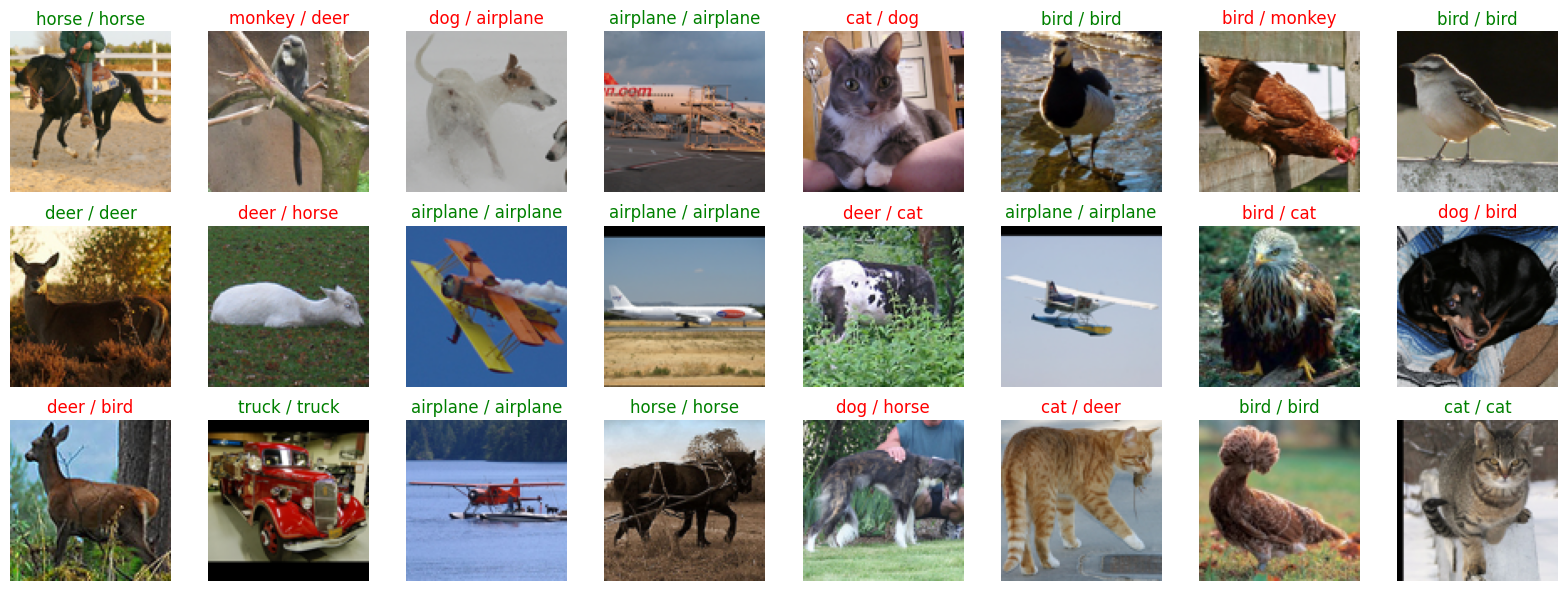

In [18]:
# ベストモデルの回答の可視化
show_images_STL10(test_dataloader, 3, model)

正解ラベルとモデルの出力を比べたものになります。  
正しく予測できているものを **緑**、間違って予測しているものを **赤** でタイトルに色付けし、可視化したものです。  
**輪郭が埋もれている画像** などに、誤った予測をしていることが視覚的に確認できます。

### **学習曲線 による可視化**


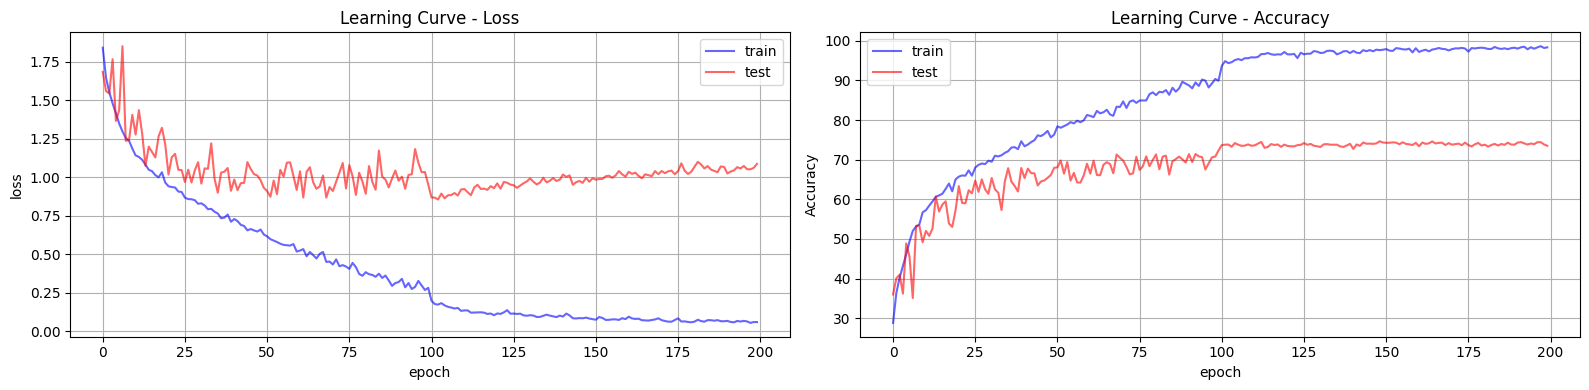

In [19]:
show_learning_curve(train_losses, train_accs, test_losses, test_accs)


**Loss（左図）** はだんだんと下がり、 **正確度（右図）** はだんだん上がっていることが確認でき、  
学習回数を増やすごとにモデルが画像の特徴を捉えて、認識していることがわかる。  
100エポック目でスケジューラーでlearning rateを変えたことにより、出力が安定している。

### **Class Activation Map（CAM）による可視化**  


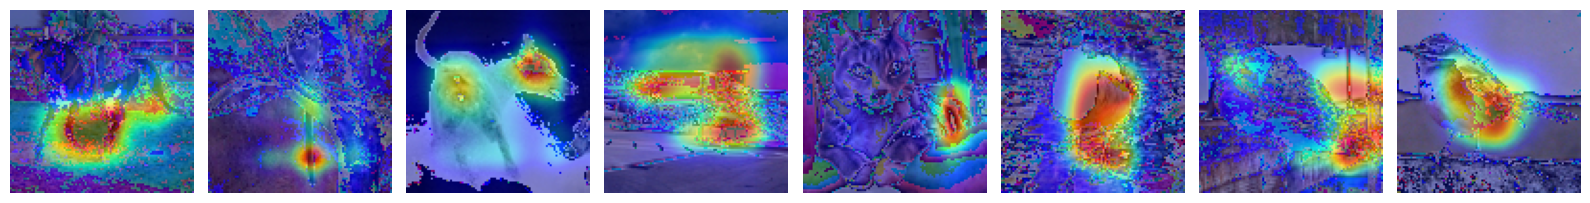

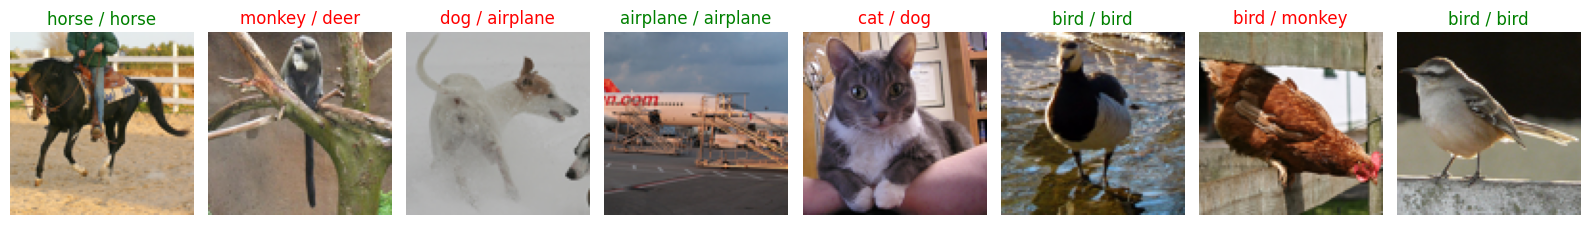

In [20]:
show_CAM_STL10(test_dataloader, model)

"**モデルの目線**" を覗き見るような感覚で、学習の理解を深めることができ、  
画像全体の中で、モデルが特に強く反応した領域を赤く表示され、分類結果の根拠を直感的に捉えるのに役立ちます。  

## ▼おわりに


本ノートブックでは、CNNの先駆けであるAlexNetから着想を得て、自分なりにモデルを構築し、**74.94％** の精度を達成しました。  
これにより、古典的な構造であっても十分な性能が得られることを確認できました。  
  
このモデルの構築を通して、下記のポイントについて理解を深めることができました。  

* **歴代モデル** の構造理解
* **データ拡張** による汎用性能向上
* モデル構築に関する実践的知見の獲得
* 学習結果の **可視化による分析**
* **現代手法（AdaptiveAvgPool2d）** の導入

次回のノートブックでは、ResNetモデルの考察に進み、  
今回のモデルをベースとして、**残差ブロックの導入** によるさらなる精度向上を目指していきます。
  
---  
  
最後までご覧いただき、ありがとうございました。  
今後もこの知見を元に、より深い知識と技術を身につけていけるよう、継続して取り組んでまいります。